
# Tutorial 7: Deep Energy-Based Generative Models

* **Author:** Phillip Lippe
* **License:** CC BY-SA
* **Generated:** 2025-05-01T10:34:52.650320

In this tutorial, we will look at energy-based deep learning models, and focus on their application as generative models.
Energy models have been a popular tool before the huge deep learning hype around 2012 hit.
However, in recent years, energy-based models have gained increasing attention because of improved training methods and tricks being proposed.
Although they are still in a research stage, they have shown to outperform strong Generative Adversarial Networks
in certain cases which have been the state of the art of generating images
([blog post](https://ajolicoeur.wordpress.com/the-new-contender-to-gans-score-matching-with-langevin-sampling/)about strong energy-based models,
[blog post](https://medium.com/syncedreview/nvidia-open-sources-hyper-realistic-face-generator-stylegan-f346e1a73826) about the power of GANs).
Hence, it is important to be aware of energy-based models, and as the theory can be abstract sometimes,
we will show the idea of energy-based models with a lot of examples.
This notebook is part of a lecture series on Deep Learning at the University of Amsterdam.
The full list of tutorials can be found at https://uvadlc-notebooks.rtfd.io.


---
Open in [Open In Colab{height="20px" width="117px"}](https://colab.research.google.com/github/PytorchLightning/lightning-tutorials/blob/publication/.notebooks/course_UvA-DL/07-deep-energy-based-generative-models.ipynb)

Give us a ⭐ [on Github](https://www.github.com/Lightning-AI/lightning/)
| Check out [the documentation](https://lightning.ai/docs/)
| Join us [on Discord](https://discord.com/invite/tfXFetEZxv)

## Setup
This notebook requires some packages besides pytorch-lightning.

In [1]:
! pip install --quiet "tensorboard" "torchvision" "matplotlib" "numpy <3.0" "torch >=1.8.1,<2.8" "torchmetrics >=1.0,<1.8" "pytorch-lightning >=2.0,<2.6" "seaborn"


[notice] A new release of pip is available: 24.2 -> 25.1
[notice] To update, run: python -m pip install --upgrade pip


<div class="center-wrapper"><div class="video-wrapper"><iframe src="https://www.youtube.com/embed/E6PDwquBBQc" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe></div></div>
First, let's import our standard libraries below.

In [2]:
# Standard libraries
import os
import random
import urllib.request
from urllib.error import HTTPError

# Plotting
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
import matplotlib_inline.backend_inline
import numpy as np

# PyTorch Lightning
import pytorch_lightning as pl

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

# Torchvision
import torchvision
from pytorch_lightning.callbacks import Callback, LearningRateMonitor, ModelCheckpoint
from torchvision import transforms
from torchvision.datasets import MNIST

matplotlib_inline.backend_inline.set_matplotlib_formats("svg", "pdf")  # For export
matplotlib.rcParams["lines.linewidth"] = 2.0

# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = os.environ.get("PATH_DATASETS", "data")
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = os.environ.get("PATH_CHECKPOINT", "saved_models/tutorial8")

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

Seed set to 42


We also have pre-trained models that we download below.

In [3]:
# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial8/"
# Files to download
pretrained_files = ["MNIST.ckpt", "tensorboards/events.out.tfevents.MNIST"]

# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if "/" in file_name:
        os.makedirs(file_path.rsplit("/", 1)[0], exist_ok=True)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print(
                "Something went wrong. Please try to download the files manually,"
                " or contact the author with the full output including the following error:\n",
                e,
            )

## Energy Models

In the first part of this tutorial, we will review the theory of the energy-based models
(the same theory has been discussed in Lecture 8).
While most of the previous models had the goal of classification or regression,
energy-based models are motivated from a different perspective: density estimation.
Given a dataset with a lot of elements, we want to estimate the probability distribution over the whole data space.
As an example, if we model images from CIFAR10, our goal would be to have a probability distribution
over all possible images of size $32\times32\times3$ where those images have a high likelihood
that look realistic and are one of the 10 CIFAR classes.
Simple methods like interpolation between images don't work because images are extremely high-dimensional
(especially for large HD images).
Hence, we turn to deep learning methods that have performed well on complex data.

However, how do we predict a probability distribution $p(\mathbf{x})$ over so many dimensions using a simple neural network?
The problem is that we cannot just predict a score between 0 and 1,
because a probability distribution over data needs to fulfill two properties:

1.
The probability distribution needs to assign any possible value of
$\mathbf{x}$ a non-negative value: $p(\mathbf{x}) \geq 0$.
2.
The probability density must sum/integrate to 1 over **all** possible inputs:
$\int_{\mathbf{x}} p(\mathbf{x}) d\mathbf{x} = 1$.

Luckily, there are actually many approaches for this, and one of them are energy-based models.
The fundamental idea of energy-based models is that you can turn any function
that predicts values larger than zero into a probability distribution by dviding by its volume.
Imagine we have a neural network, which has as output a single neuron, like in regression.
We can call this network $E_{\theta}(\mathbf{x})$, where $\theta$ are our parameters of the network,
and $\mathbf{x}$ the input data (e.g. an image).
The output of $E_{\theta}$ is a scalar value between $-\infty$ and $\infty$.
Now, we can use basic probability theory to *normalize* the scores of all possible inputs:

$$
q_{\theta}(\mathbf{x}) = \frac{\exp\left(-E_{\theta}(\mathbf{x})\right)}{Z_{\theta}} \hspace{5mm}\text{where}\hspace{5mm}
Z_{\theta} = \begin{cases}
    \int_{\mathbf{x}}\exp\left(-E_{\theta}(\mathbf{x})\right) d\mathbf{x} & \text{if }x\text{ is continuous}\\
    \sum_{\mathbf{x}}\exp\left(-E_{\theta}(\mathbf{x})\right) & \text{if }x\text{ is discrete}
\end{cases}
$$

The $\exp$-function ensures that we assign a probability greater than zero to any possible input.
We use a negative sign in front of $E$ because we call $E_{\theta}$ to be the energy function:
data points with high likelihood have a low energy, while data points with low likelihood have a high energy.
$Z_{\theta}$ is our normalization terms that ensures that the density integrates/sums to 1.
We can show this by integrating over $q_{\theta}(\mathbf{x})$:

$$
\int_{\mathbf{x}}q_{\theta}(\mathbf{x})d\mathbf{x} =
\int_{\mathbf{x}}\frac{\exp\left(-E_{\theta}(\mathbf{x})\right)}{\int_{\mathbf{\tilde{x}}}\exp\left(-E_{\theta}(\mathbf{\tilde{x}})\right) d\mathbf{\tilde{x}}}d\mathbf{x} =
\frac{\int_{\mathbf{x}}\exp\left(-E_{\theta}(\mathbf{x})\right)d\mathbf{x}}{\int_{\mathbf{\tilde{x}}}\exp\left(-E_{\theta}(\mathbf{\tilde{x}})\right) d\mathbf{\tilde{x}}} = 1
$$

Note that we call the probability distribution $q_{\theta}(\mathbf{x})$ because this is the learned distribution by the model,
and is trained to be as close as possible to the *true*, unknown distribution $p(\mathbf{x})$.

The main benefit of this formulation of the probability distribution is its great flexibility as we can choose
$E_{\theta}$ in whatever way we like, without any constraints.
Nevertheless, when looking at the equation above, we can see a fundamental issue: How do we calculate $Z_{\theta}$?
There is no chance that we can calculate $Z_{\theta}$ analytically for high-dimensional input
and/or larger neural networks, but the task requires us to know $Z_{\theta}$.
Although we can't determine the exact likelihood of a point, there exist methods with which we can train energy-based models.
Thus, we will look next at "Contrastive Divergence" for training the model.

### Contrastive Divergence

When we train a model on generative modeling, it is usually done by maximum likelihood estimation.
In other words, we try to maximize the likelihood of the examples in the training set.
As the exact likelihood of a point cannot be determined due to the unknown normalization constant $Z_{\theta}$,
we need to train energy-based models slightly different.
We cannot just maximize the un-normalized probability $\exp(-E_{\theta}(\mathbf{x}_{\text{train}}))$
because there is no guarantee that $Z_{\theta}$ stays constant, or that $\mathbf{x}_{\text{train}}$
is becoming more likely than the others.
However, if we base our training on comparing the likelihood of points, we can create a stable objective.
Namely, we can re-write our maximum likelihood objective where we maximize the probability
of $\mathbf{x}_{\text{train}}$ compared to a randomly sampled data point of our model:

$$
\begin{split}
    \nabla_{\theta}\mathcal{L}_{\text{MLE}}(\mathbf{\theta};p) & = -\mathbb{E}_{p(\mathbf{x})}\left[\nabla_{\theta}\log q_{\theta}(\mathbf{x})\right]\\[5pt]
    & = \mathbb{E}_{p(\mathbf{x})}\left[\nabla_{\theta}E_{\theta}(\mathbf{x})\right] - \mathbb{E}_{q_{\theta}(\mathbf{x})}\left[\nabla_{\theta}E_{\theta}(\mathbf{x})\right]
\end{split}
$$

Note that the loss is still an objective we want to minimize.
Thus, we try to minimize the energy for data points from the dataset, while maximizing the energy for randomly
sampled data points from our model (how we sample will be explained below).
Although this objective sounds intuitive, how is it actually derived from our original distribution $q_{\theta}(\mathbf{x})$?
The trick is that we approximate $Z_{\theta}$ by a single Monte-Carlo sample.
This gives us the exact same objective as written above.

Visually, we can look at the objective as follows (figure credit - Stefano Ermon and Aditya Grover: lecture cs236/11):

<center width="100%"><img src="https://github.com/Lightning-AI/lightning-tutorials/raw/main/course_UvA-DL/07-deep-energy-based-generative-models/contrastive_divergence.svg" width="700px"></center>

$f_{\theta}$ represents $\exp(-E_{\theta}(\mathbf{x}))$ in our case.
The point on the right, called "correct answer", represents a data point from the dataset
(i.e. $x_{\text{train}}$), and the left point, "wrong answer", a sample from our model (i.e. $x_{\text{sample}}$).
Thus, we try to "pull up" the probability of the data points in the dataset,
while "pushing down" randomly sampled points.
The two forces for pulling and pushing are in balance iff $q_{\theta}(\mathbf{x})=p(\mathbf{x})$.

### Sampling from Energy-Based Models

For sampling from an energy-based model, we can apply a Markov Chain Monte Carlo using Langevin Dynamics.
The idea of the algorithm is to start from a random point, and slowly move towards the direction
of higher probability using the gradients of $E_{\theta}$.
Nevertheless, this is not enough to fully capture the probability distribution.
We need to add noise $\omega$ at each gradient step to the current sample.
Under certain conditions such as that we perform the gradient steps an infinite amount of times,
we would be able to create an exact sample from our modeled distribution.
However, as this is not practically possible, we usually limit the chain to $K$ steps
($K$ a hyperparameter that needs to be finetuned).
Overall, the sampling procedure can be summarized in the following algorithm:

<center width="100%" style="padding:15px"><img src="https://github.com/Lightning-AI/lightning-tutorials/raw/main/course_UvA-DL/07-deep-energy-based-generative-models/sampling.svg" width="750px"></center>

### Applications of Energy-based models beyond generation

Modeling the probability distribution for sampling new data is not the only application of energy-based models.
Any application which requires us to compare two elements is much simpler to learn
because we just need to go for the higher energy.
A couple of examples are shown below (figure credit - Stefano Ermon and Aditya Grover: lecture cs236/11).
A classification setup like object recognition or sequence labeling can be considered as an energy-based
task as we just need to find the $Y$ input that minimizes the output $E(X, Y)$ (hence maximizes probability).
Similarly, a popular application of energy-based models is denoising of images.
Given an image $X$ with a lot of noise, we try to minimize the energy by finding the true input image $Y$.

<center width="100%"><img src="https://github.com/Lightning-AI/lightning-tutorials/raw/main/course_UvA-DL/07-deep-energy-based-generative-models/energy_models_application.png" width="600px"></center>

Nonetheless, we will focus on generative modeling here as in the next couple of lectures,
we will discuss more generative deep learning approaches.

## Image generation

<div class="center-wrapper"><div class="video-wrapper"><iframe src="https://www.youtube.com/embed/QJ94zuSQoP4" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe></div></div>

As an example for energy-based models, we will train a model on image generation.
Specifically, we will look at how we can generate MNIST digits with a very simple CNN model.
However, it should be noted that energy models are not easy to train and often diverge
if the hyperparameters are not well tuned.
We will rely on training tricks proposed in the paper
[Implicit Generation and Generalization in Energy-Based Models](https://arxiv.org/abs/1903.08689)
by Yilun Du and Igor Mordatch ([blog](https://openai.com/index/energy-based-models/)).
The important part of this notebook is however to see how the theory above can actually be used in a model.

### Dataset

First, we can load the MNIST dataset below.
Note that we need to normalize the images between -1 and 1 instead of mean 0 and std 1 because during sampling,
we have to limit the input space.
Scaling between -1 and 1 makes it easier to implement it.

In [4]:
# Transformations applied on each image => make them a tensor and normalize between -1 and 1
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Loading the training dataset. We need to split it into a training and validation part
train_set = MNIST(root=DATASET_PATH, train=True, transform=transform, download=True)

# Loading the test set
test_set = MNIST(root=DATASET_PATH, train=False, transform=transform, download=True)

# We define a set of data loaders that we can use for various purposes later.
# Note that for actually training a model, we will use different data loaders
# with a lower batch size.
train_loader = data.DataLoader(train_set, batch_size=128, shuffle=True, drop_last=True, num_workers=4, pin_memory=True)
test_loader = data.DataLoader(test_set, batch_size=256, shuffle=False, drop_last=False, num_workers=4)

Failed to download (trying next):
HTTP Error 404: Not Found



  0%|          | 0/9912422 [00:00<?, ?it/s]

 29%|██▉       | 2850816/9912422 [00:00<00:00, 28386096.45it/s]

 78%|███████▊  | 7766016/9912422 [00:00<00:00, 40435977.33it/s]

100%|██████████| 9912422/9912422 [00:00<00:00, 40504804.71it/s]

Extracting /__w/11/s/.datasets/MNIST/raw/train-images-idx3-ubyte.gz to /__w/11/s/.datasets/MNIST/raw



Failed to download (trying next):
HTTP Error 404: Not Found



  0%|          | 0/28881 [00:00<?, ?it/s]

100%|██████████| 28881/28881 [00:00<00:00, 3000785.12it/s]

Extracting /__w/11/s/.datasets/MNIST/raw/train-labels-idx1-ubyte.gz to /__w/11/s/.datasets/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



  0%|          | 0/1648877 [00:00<?, ?it/s]

100%|██████████| 1648877/1648877 [00:00<00:00, 21243780.19it/s]

Extracting /__w/11/s/.datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to /__w/11/s/.datasets/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



  0%|          | 0/4542 [00:00<?, ?it/s]

100%|██████████| 4542/4542 [00:00<00:00, 5702043.93it/s]

Extracting /__w/11/s/.datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to /__w/11/s/.datasets/MNIST/raw



### CNN Model

First, we implement our CNN model.
The MNIST images are of size 28x28, hence we only need a small model.
As an example, we will apply several convolutions with stride 2 that downscale the images.
If you are interested, you can also use a deeper model such as a small ResNet, but for simplicity,
we will stick with the tiny network.

It is a good practice to use a smooth activation function like Swish instead of ReLU in the energy model.
This is because we will rely on the gradients we get back with respect to the input image, which should not be sparse.

In [5]:
class CNNModel(nn.Module):
    def __init__(self, hidden_features=32, out_dim=1, **kwargs):
        super().__init__()
        # We increase the hidden dimension over layers. Here pre-calculated for simplicity.
        c_hid1 = hidden_features // 2
        c_hid2 = hidden_features
        c_hid3 = hidden_features * 2

        # Series of convolutions and Swish activation functions
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(1, c_hid1, kernel_size=5, stride=2, padding=4),  # [16x16] - Larger padding to get 32x32 image
            nn.SiLU(),
            nn.Conv2d(c_hid1, c_hid2, kernel_size=3, stride=2, padding=1),  # [8x8]
            nn.SiLU(),
            nn.Conv2d(c_hid2, c_hid3, kernel_size=3, stride=2, padding=1),  # [4x4]
            nn.SiLU(),
            nn.Conv2d(c_hid3, c_hid3, kernel_size=3, stride=2, padding=1),  # [2x2]
            nn.SiLU(),
            nn.Flatten(),
            nn.Linear(c_hid3 * 4, c_hid3),
            nn.SiLU(),
            nn.Linear(c_hid3, out_dim),
        )

    def forward(self, x):
        x = self.cnn_layers(x).squeeze(dim=-1)
        return x

In the rest of the notebook, the output of the model will actually not represent
$E_{\theta}(\mathbf{x})$, but $-E_{\theta}(\mathbf{x})$.
This is a standard implementation practice for energy-based models, as some people also write the energy probability
density as $q_{\theta}(\mathbf{x}) = \frac{\exp\left(f_{\theta}(\mathbf{x})\right)}{Z_{\theta}}$.
In that case, the model would actually represent $f_{\theta}(\mathbf{x})$.
In the training loss etc., we need to be careful to not switch up the signs.

### Sampling buffer

In the next part, we look at the training with sampled elements.
To use the contrastive divergence objective, we need to generate samples during training.
Previous work has shown that due to the high dimensionality of images, we need a lot of iterations
inside the MCMC sampling to obtain reasonable samples.
However, there is a training trick that significantly reduces the sampling cost: using a sampling buffer.
The idea is that we store the samples of the last couple of batches in a buffer,
and reuse those as the starting point of the MCMC algorithm for the next batches.
This reduces the sampling cost because the model requires a significantly
lower number of steps to converge to reasonable samples.
However, to not solely rely on previous samples and allow novel samples as well,
we re-initialize 5% of our samples from scratch (random noise between -1 and 1).

Below, we implement the sampling buffer.
The function `sample_new_exmps` returns a new batch of "fake" images.
We refer to those as fake images because they have been generated, but are not actually part of the dataset.
As mentioned before, we use initialize 5% randomly, and 95% are randomly picked from our buffer.
On this initial batch, we perform MCMC for 60 iterations to improve the image quality
and come closer to samples from $q_{\theta}(\mathbf{x})$.
In the function `generate_samples`, we implemented the MCMC for images.
Note that the hyperparameters of `step_size`, `steps`, the noise standard deviation
$\sigma$ are specifically set for MNIST, and need to be finetuned for a different dataset if you want to use such.

In [6]:
class Sampler:
    def __init__(self, model, img_shape, sample_size, max_len=8192):
        """Sampler.

        Args:
            model: Neural network to use for modeling E_theta
            img_shape: Shape of the images to model
            sample_size: Batch size of the samples
            max_len: Maximum number of data points to keep in the buffer

        """
        super().__init__()
        self.model = model
        self.img_shape = img_shape
        self.sample_size = sample_size
        self.max_len = max_len
        self.examples = [(torch.rand((1,) + img_shape) * 2 - 1) for _ in range(self.sample_size)]

    def sample_new_exmps(self, steps=60, step_size=10):
        """Function for getting a new batch of "fake" images.

        Args:
            steps: Number of iterations in the MCMC algorithm
            step_size: Learning rate nu in the algorithm above

        """
        # Choose 95% of the batch from the buffer, 5% generate from scratch
        n_new = np.random.binomial(self.sample_size, 0.05)
        rand_imgs = torch.rand((n_new,) + self.img_shape) * 2 - 1
        old_imgs = torch.cat(random.choices(self.examples, k=self.sample_size - n_new), dim=0)
        inp_imgs = torch.cat([rand_imgs, old_imgs], dim=0).detach().to(device)

        # Perform MCMC sampling
        inp_imgs = Sampler.generate_samples(self.model, inp_imgs, steps=steps, step_size=step_size)

        # Add new images to the buffer and remove old ones if needed
        self.examples = list(inp_imgs.to(torch.device("cpu")).chunk(self.sample_size, dim=0)) + self.examples
        self.examples = self.examples[: self.max_len]
        return inp_imgs

    @staticmethod
    def generate_samples(model, inp_imgs, steps=60, step_size=10, return_img_per_step=False):
        """Function for sampling images for a given model.

        Args:
            model: Neural network to use for modeling E_theta
            inp_imgs: Images to start from for sampling. If you want to generate new images, enter noise between -1 and 1.
            steps: Number of iterations in the MCMC algorithm.
            step_size: Learning rate nu in the algorithm above
            return_img_per_step: If True, we return the sample at every iteration of the MCMC

        """
        # Before MCMC: set model parameters to "required_grad=False"
        # because we are only interested in the gradients of the input.
        is_training = model.training
        model.eval()
        for p in model.parameters():
            p.requires_grad = False
        inp_imgs.requires_grad = True

        # Enable gradient calculation if not already the case
        had_gradients_enabled = torch.is_grad_enabled()
        torch.set_grad_enabled(True)

        # We use a buffer tensor in which we generate noise each loop iteration.
        # More efficient than creating a new tensor every iteration.
        noise = torch.randn(inp_imgs.shape, device=inp_imgs.device)

        # List for storing generations at each step (for later analysis)
        imgs_per_step = []

        # Loop over K (steps)
        for _ in range(steps):
            # Part 1: Add noise to the input.
            noise.normal_(0, 0.005)
            inp_imgs.data.add_(noise.data)
            inp_imgs.data.clamp_(min=-1.0, max=1.0)

            # Part 2: calculate gradients for the current input.
            out_imgs = -model(inp_imgs)
            out_imgs.sum().backward()
            inp_imgs.grad.data.clamp_(-0.03, 0.03)  # For stabilizing and preventing too high gradients

            # Apply gradients to our current samples
            inp_imgs.data.add_(-step_size * inp_imgs.grad.data)
            inp_imgs.grad.detach_()
            inp_imgs.grad.zero_()
            inp_imgs.data.clamp_(min=-1.0, max=1.0)

            if return_img_per_step:
                imgs_per_step.append(inp_imgs.clone().detach())

        # Reactivate gradients for parameters for training
        for p in model.parameters():
            p.requires_grad = True
        model.train(is_training)

        # Reset gradient calculation to setting before this function
        torch.set_grad_enabled(had_gradients_enabled)

        if return_img_per_step:
            return torch.stack(imgs_per_step, dim=0)
        else:
            return inp_imgs

The idea of the buffer becomes a bit clearer in the following algorithm.

### Training algorithm

With the sampling buffer being ready, we can complete our training algorithm.
Below is shown a summary of the full training algorithm of an energy model on image modeling:

<center width="100%" style="padding: 15px"><img src="https://github.com/Lightning-AI/lightning-tutorials/raw/main/course_UvA-DL/07-deep-energy-based-generative-models/training_algorithm.svg" width="700px"></center>

The first few statements in each training iteration concern the sampling of the real and fake data,
as we have seen above with the sample buffer.
Next, we calculate the contrastive divergence objective using our energy model $E_{\theta}$.
However, one additional training trick we need is to add a regularization loss on the output of $E_{\theta}$.
As the output of the network is not constrained and adding a large bias or not to the output
doesn't change the contrastive divergence loss, we need to ensure somehow else that the output values are in a reasonable range.
Without the regularization loss, the output values will fluctuate in a very large range.
With this, we ensure that the values for the real data are around 0, and the fake data likely slightly lower
(for noise or outliers the score can be still significantly lower).
As the regularization loss is less important than the Contrastive Divergence, we have a weight factor
$\alpha$ which is usually quite some smaller than 1.
Finally, we perform an update step with an optimizer on the combined loss and add the new samples to the buffer.

Below, we put this training dynamic into a PyTorch Lightning module:

In [7]:
class DeepEnergyModel(pl.LightningModule):
    def __init__(self, img_shape, batch_size, alpha=0.1, lr=1e-4, beta1=0.0, **CNN_args):
        super().__init__()
        self.save_hyperparameters()

        self.cnn = CNNModel(**CNN_args)
        self.sampler = Sampler(self.cnn, img_shape=img_shape, sample_size=batch_size)
        self.example_input_array = torch.zeros(1, *img_shape)

    def forward(self, x):
        z = self.cnn(x)
        return z

    def configure_optimizers(self):
        # Energy models can have issues with momentum as the loss surfaces changes with its parameters.
        # Hence, we set it to 0 by default.
        optimizer = optim.Adam(self.parameters(), lr=self.hparams.lr, betas=(self.hparams.beta1, 0.999))
        scheduler = optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.97)  # Exponential decay over epochs
        return [optimizer], [scheduler]

    def training_step(self, batch, batch_idx):
        # We add minimal noise to the original images to prevent the model from focusing on purely "clean" inputs
        real_imgs, _ = batch
        small_noise = torch.randn_like(real_imgs) * 0.005
        real_imgs.add_(small_noise).clamp_(min=-1.0, max=1.0)

        # Obtain samples
        fake_imgs = self.sampler.sample_new_exmps(steps=60, step_size=10)

        # Predict energy score for all images
        inp_imgs = torch.cat([real_imgs, fake_imgs], dim=0)
        real_out, fake_out = self.cnn(inp_imgs).chunk(2, dim=0)

        # Calculate losses
        reg_loss = self.hparams.alpha * (real_out**2 + fake_out**2).mean()
        cdiv_loss = fake_out.mean() - real_out.mean()
        loss = reg_loss + cdiv_loss

        # Logging
        self.log("loss", loss)
        self.log("loss_regularization", reg_loss)
        self.log("loss_contrastive_divergence", cdiv_loss)
        self.log("metrics_avg_real", real_out.mean())
        self.log("metrics_avg_fake", fake_out.mean())
        return loss

    def validation_step(self, batch, batch_idx):
        # For validating, we calculate the contrastive divergence between purely random images and unseen examples
        # Note that the validation/test step of energy-based models depends on what we are interested in the model
        real_imgs, _ = batch
        fake_imgs = torch.rand_like(real_imgs) * 2 - 1

        inp_imgs = torch.cat([real_imgs, fake_imgs], dim=0)
        real_out, fake_out = self.cnn(inp_imgs).chunk(2, dim=0)

        cdiv = fake_out.mean() - real_out.mean()
        self.log("val_contrastive_divergence", cdiv)
        self.log("val_fake_out", fake_out.mean())
        self.log("val_real_out", real_out.mean())

We do not implement a test step because energy-based, generative models are usually not evaluated on a test set.
The validation step however is used to get an idea of the difference between ennergy/likelihood
of random images to unseen examples of the dataset.

### Callbacks

To track the performance of our model during training, we will make extensive use of PyTorch Lightning's callback framework.
Remember that callbacks can be used for running small functions at any point of the training,
for instance after finishing an epoch.
Here, we will use three different callbacks we define ourselves.

The first callback, called `GenerateCallback`, is used for adding image generations to the model during training.
After every $N$ epochs (usually $N=5$ to reduce output to TensorBoard), we take a small batch
of random images and perform many MCMC iterations until the model's generation converges.
Compared to the training that used 60 iterations, we use 256 here because
(1) we only have to do it once compared to the training that has to do it every iteration, and
(2) we do not start from a buffer here, but from scratch.
It is implemented as follows:

In [8]:
class GenerateCallback(Callback):
    def __init__(self, batch_size=8, vis_steps=8, num_steps=256, every_n_epochs=5):
        super().__init__()
        self.batch_size = batch_size  # Number of images to generate
        self.vis_steps = vis_steps  # Number of steps within generation to visualize
        self.num_steps = num_steps  # Number of steps to take during generation
        # Only save those images every N epochs (otherwise tensorboard gets quite large)
        self.every_n_epochs = every_n_epochs

    def on_epoch_end(self, trainer, pl_module):
        # Skip for all other epochs
        if trainer.current_epoch % self.every_n_epochs == 0:
            # Generate images
            imgs_per_step = self.generate_imgs(pl_module)
            # Plot and add to tensorboard
            for i in range(imgs_per_step.shape[1]):
                step_size = self.num_steps // self.vis_steps
                imgs_to_plot = imgs_per_step[step_size - 1 :: step_size, i]
                grid = torchvision.utils.make_grid(
                    imgs_to_plot, nrow=imgs_to_plot.shape[0], normalize=True, value_range=(-1, 1)
                )
                trainer.logger.experiment.add_image(f"generation_{i}", grid, global_step=trainer.current_epoch)

    def generate_imgs(self, pl_module):
        pl_module.eval()
        start_imgs = torch.rand((self.batch_size,) + pl_module.hparams["img_shape"]).to(pl_module.device)
        start_imgs = start_imgs * 2 - 1
        imgs_per_step = Sampler.generate_samples(
            pl_module.cnn, start_imgs, steps=self.num_steps, step_size=10, return_img_per_step=True
        )
        pl_module.train()
        return imgs_per_step

The second callback is called `SamplerCallback`, and simply adds a randomly picked subset of images
in the sampling buffer to the TensorBoard.
This helps to understand what images are currently shown to the model as "fake".

In [9]:
class SamplerCallback(Callback):
    def __init__(self, num_imgs=32, every_n_epochs=5):
        super().__init__()
        self.num_imgs = num_imgs  # Number of images to plot
        # Only save those images every N epochs (otherwise tensorboard gets quite large)
        self.every_n_epochs = every_n_epochs

    def on_epoch_end(self, trainer, pl_module):
        if trainer.current_epoch % self.every_n_epochs == 0:
            exmp_imgs = torch.cat(random.choices(pl_module.sampler.examples, k=self.num_imgs), dim=0)
            grid = torchvision.utils.make_grid(exmp_imgs, nrow=4, normalize=True, value_range=(-1, 1))
            trainer.logger.experiment.add_image("sampler", grid, global_step=trainer.current_epoch)

Finally, our last callback is `OutlierCallback`.
This callback evaluates the model by recording the (negative) energy assigned to random noise.
While our training loss is almost constant across iterations,
this score is likely showing the progress of the model to detect "outliers".

In [10]:
class OutlierCallback(Callback):
    def __init__(self, batch_size=1024):
        super().__init__()
        self.batch_size = batch_size

    def on_epoch_end(self, trainer, pl_module):
        with torch.no_grad():
            pl_module.eval()
            rand_imgs = torch.rand((self.batch_size,) + pl_module.hparams["img_shape"]).to(pl_module.device)
            rand_imgs = rand_imgs * 2 - 1.0
            rand_out = pl_module.cnn(rand_imgs).mean()
            pl_module.train()

        trainer.logger.experiment.add_scalar("rand_out", rand_out, global_step=trainer.current_epoch)

### Running the model

Finally, we can add everything together to create our final training function.
The function is very similar to any other PyTorch Lightning training function we have seen so far.
However, there is the small difference of that we do not test the model on a test set
because we will analyse the model afterward by checking its prediction and ability to perform outlier detection.

In [11]:
def train_model(**kwargs):
    # Create a PyTorch Lightning trainer with the generation callback
    trainer = pl.Trainer(
        default_root_dir=os.path.join(CHECKPOINT_PATH, "MNIST"),
        accelerator="auto",
        devices=1,
        max_epochs=60,
        gradient_clip_val=0.1,
        callbacks=[
            ModelCheckpoint(save_weights_only=True, mode="min", monitor="val_contrastive_divergence"),
            GenerateCallback(every_n_epochs=5),
            SamplerCallback(every_n_epochs=5),
            OutlierCallback(),
            LearningRateMonitor("epoch"),
        ],
    )
    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, "MNIST.ckpt")
    if os.path.isfile(pretrained_filename):
        print("Found pretrained model, loading...")
        model = DeepEnergyModel.load_from_checkpoint(pretrained_filename)
    else:
        pl.seed_everything(42)
        model = DeepEnergyModel(**kwargs)
        trainer.fit(model, train_loader, test_loader)
        model = DeepEnergyModel.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)
    # No testing as we are more interested in other properties
    return model

In [12]:
model = train_model(img_shape=(1, 28, 28), batch_size=train_loader.batch_size, lr=1e-4, beta1=0.0)

GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs


Found pretrained model, loading...


Lightning automatically upgraded your loaded checkpoint from v1.0.2 to v2.4.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint saved_models/tutorial8/MNIST.ckpt`


## Analysis

In the last part of the notebook, we will try to take the trained energy-based generative model,
and analyse its properties.

### TensorBoard

The first thing we can look at is the TensorBoard generate during training.
This can help us to understand the training dynamic even better, and shows potential issues.
Let's load the TensorBoard below:

In [13]:
# Uncomment the following two lines to open a tensorboard in the notebook.
# Adjust the path to your CHECKPOINT_PATH if needed.
%load_ext tensorboard
%tensorboard --logdir ../saved_models/tutorial8/tensorboards/

<center width="100%"><img src="https://github.com/Lightning-AI/lightning-tutorials/raw/main/course_UvA-DL/07-deep-energy-based-generative-models/tensorboard_screenshot.png" width="1000px"></center>

We see that the contrastive divergence as well as the regularization converge quickly to 0.
However, the training continues although the loss is always close to zero.
This is because our "training" data changes with the model by sampling.
The progress of training can be best measured by looking at the samples across iterations,
and the score for random images that decreases constantly over time.

### Image Generation

Another way of evaluating generative models is by sampling a few generated images.
Generative models need to be good at generating realistic images as this truly shows that they have modeled the true data distribution.
Thus, let's sample a few images of the model below:

In [14]:
model.to(device)
pl.seed_everything(43)
callback = GenerateCallback(batch_size=4, vis_steps=8, num_steps=256)
imgs_per_step = callback.generate_imgs(model)
imgs_per_step = imgs_per_step.cpu()

Seed set to 43


The characteristic of sampling with energy-based models is that they require the iterative MCMC algorithm.
To gain an insight in how the images change over iterations, we plot a few intermediate samples in the MCMC as well:

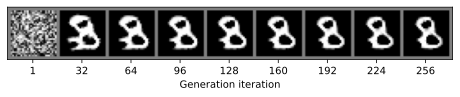

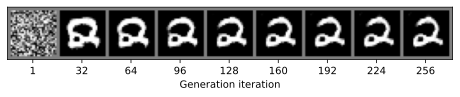

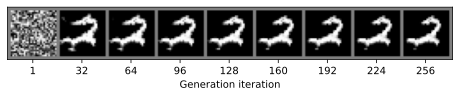

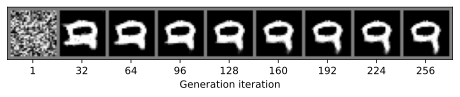

In [15]:
for i in range(imgs_per_step.shape[1]):
    step_size = callback.num_steps // callback.vis_steps
    imgs_to_plot = imgs_per_step[step_size - 1 :: step_size, i]
    imgs_to_plot = torch.cat([imgs_per_step[0:1, i], imgs_to_plot], dim=0)
    grid = torchvision.utils.make_grid(
        imgs_to_plot, nrow=imgs_to_plot.shape[0], normalize=True, value_range=(-1, 1), pad_value=0.5, padding=2
    )
    grid = grid.permute(1, 2, 0)
    plt.figure(figsize=(8, 8))
    plt.imshow(grid)
    plt.xlabel("Generation iteration")
    plt.xticks(
        [(imgs_per_step.shape[-1] + 2) * (0.5 + j) for j in range(callback.vis_steps + 1)],
        labels=[1] + list(range(step_size, imgs_per_step.shape[0] + 1, step_size)),
    )
    plt.yticks([])
    plt.show()

We see that although starting from noise in the very first step, the sampling algorithm obtains reasonable shapes after only 32 steps.
Over the next 200 steps, the shapes become clearer and changed towards realistic digits.
The specific samples can differ when you run the code on Colab, hence the following description is specific to the plots shown on the website.
The first row shows an 8, where we remove unnecessary white parts over iterations.
The transformation across iterations can be seen at best for the second sample, which creates a digit of 2.
While the first sample after 32 iterations looks a bit like a digit, but not really,
the sample is transformed more and more to a typical image of the digit 2.

### Out-of-distribution detection

A very common and strong application of energy-based models is out-of-distribution detection
(sometimes referred to as "anomaly" detection).
As more and more deep learning models are applied in production and applications,
a crucial aspect of these models is to know what the models don't know.
Deep learning models are usually overconfident, meaning that they classify even random images sometimes with 100% probability.
Clearly, this is not something that we want to see in applications.
Energy-based models can help with this problem because they are trained to detect images that do not fit the training dataset distribution.
Thus, in those applications, you could train an energy-based model along with the classifier,
and only output predictions if the energy-based models assign a (unnormalized) probability higher than $\delta$ to the image.
You can actually combine classifiers and energy-based objectives in a single model,
as proposed in this [paper](https://arxiv.org/abs/1912.03263).

In this part of the analysis, we want to test the out-of-distribution capability of our energy-based model.
Remember that a lower output of the model denotes a low probability.
Thus, we hope to see low scores if we enter random noise to the model:

In [16]:
with torch.no_grad():
    rand_imgs = torch.rand((128,) + model.hparams.img_shape).to(model.device)
    rand_imgs = rand_imgs * 2 - 1.0
    rand_out = model.cnn(rand_imgs).mean()
    print(f"Average score for random images: {rand_out.item()}")

Average score for random images: -17.878559112548828


As we hoped, the model assigns very low probability to those noisy images.
As another reference, let's look at predictions for a batch of images from the training set:

In [17]:
with torch.no_grad():
    train_imgs, _ = next(iter(train_loader))
    train_imgs = train_imgs.to(model.device)
    train_out = model.cnn(train_imgs).mean()
    print(f"Average score for training images: {train_out.item():4.2f}")

Average score for training images: -0.01


The scores are close to 0 because of the regularization objective that was added to the training.
So clearly, the model can distinguish between noise and real digits.
However, what happens if we change the training images a little, and see which ones gets a very low score?

In [18]:
@torch.no_grad()
def compare_images(img1, img2):
    imgs = torch.stack([img1, img2], dim=0).to(model.device)
    score1, score2 = model.cnn(imgs).cpu().chunk(2, dim=0)
    grid = torchvision.utils.make_grid(
        [img1.cpu(), img2.cpu()], nrow=2, normalize=True, value_range=(-1, 1), pad_value=0.5, padding=2
    )
    grid = grid.permute(1, 2, 0)
    plt.figure(figsize=(4, 4))
    plt.imshow(grid)
    plt.xticks([(img1.shape[2] + 2) * (0.5 + j) for j in range(2)], labels=["Original image", "Transformed image"])
    plt.yticks([])
    plt.show()
    print(f"Score original image: {score1}")
    print(f"Score transformed image: {score2}")

We use a random test image for this. Feel free to change it to experiment with the model yourself.

In [19]:
test_imgs, _ = next(iter(test_loader))
exmp_img = test_imgs[0].to(model.device)

The first transformation is to add some random noise to the image:

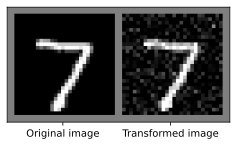

Score original image: tensor([0.0304])
Score transformed image: tensor([-0.0746])


In [20]:
img_noisy = exmp_img + torch.randn_like(exmp_img) * 0.3
img_noisy.clamp_(min=-1.0, max=1.0)
compare_images(exmp_img, img_noisy)

We can see that the score considerably drops.
Hence, the model can detect random Gaussian noise on the image.
This is also to expect as initially, the "fake" samples are pure noise images.

Next, we flip an image and check how this influences the score:

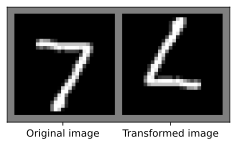

Score original image: tensor([0.0304])
Score transformed image: tensor([-0.0004])


In [21]:
img_flipped = exmp_img.flip(dims=(1, 2))
compare_images(exmp_img, img_flipped)

If the digit can only be read in this way, for example, the 7, then we can see that the score drops.
However, the score only drops slightly.
This is likely because of the small size of our model.
Keep in mind that generative modeling is a much harder task than classification,
as we do not only need to distinguish between classes but learn **all** details/characteristics of the digits.
With a deeper model, this could eventually be captured better (but at the cost of greater training instability).

Finally, we check what happens if we reduce the digit significantly in size:

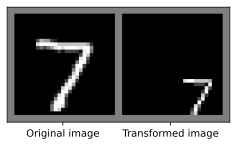

Score original image: tensor([0.0304])
Score transformed image: tensor([-0.0154])


In [22]:
img_tiny = torch.zeros_like(exmp_img) - 1
img_tiny[:, exmp_img.shape[1] // 2 :, exmp_img.shape[2] // 2 :] = exmp_img[:, ::2, ::2]
compare_images(exmp_img, img_tiny)

The score again drops but not by a large margin, although digits in the MNIST dataset usually are much larger.

Overall, we can conclude that our model is good for detecting Gaussian noise and smaller transformations to existing digits.
Nonetheless, to obtain a very good out-of-distribution model, we would need to train deeper models and for more iterations.

### Instability

Finally, we should discuss the possible instabilities of energy-based models,
in particular for the example of image generation that we have implemented in this notebook.
In the process of hyperparameter search for this notebook, there have been several models that diverged.
Divergence in energy-based models means that the models assign a high probability to examples of the training set which is a good thing.
However, at the same time, the sampling algorithm fails and only generates noise images that obtain minimal probability scores.
This happens because the model has created many local maxima in which the generated noise images fall.
The energy surface over which we calculate the gradients to reach data points with high probability has "diverged" and is not useful for our MCMC sampling.

Besides finding the optimal hyperparameters, a common trick in energy-based models is to reload stable checkpoints.
If we detect that the model is diverging, we stop the training, load the model from one epoch ago where it did not diverge yet.
Afterward, we continue training and hope that with a different seed the model is not diverging again.
Nevertheless, this should be considered as the "last hope" for stabilizing the models,
and careful hyperparameter tuning is the better way to do so.
Sensitive hyperparameters include `step_size`, `steps` and the noise standard deviation in the sampler,
and the learning rate and feature dimensionality in the CNN model.

## Conclusion

In this tutorial, we have discussed energy-based models for generative modeling.
The concept relies on the idea that any strictly positive function can be turned into a probability
distribution by normalizing over the whole dataset.
As this is not reasonable to calculate for high dimensional data like images,
we train the model using contrastive divergence and sampling via MCMC.
While the idea allows us to turn any neural network into an energy-based model,
we have seen that there are multiple training tricks needed to stabilize the training.
Furthermore, the training time of these models is relatively long as, during every training iteration,
we need to sample new "fake" images, even with a sampling buffer.
In the next lectures and assignment, we will see different generative models (e.g. VAE, GAN, NF)
that allow us to do generative modeling more stably, but with the cost of more parameters.

## Congratulations - Time to Join the Community!

Congratulations on completing this notebook tutorial! If you enjoyed this and would like to join the Lightning
movement, you can do so in the following ways!

### Star [Lightning](https://github.com/Lightning-AI/lightning) on GitHub
The easiest way to help our community is just by starring the GitHub repos! This helps raise awareness of the cool
tools we're building.

### Join our [Discord](https://discord.com/invite/tfXFetEZxv)!
The best way to keep up to date on the latest advancements is to join our community! Make sure to introduce yourself
and share your interests in `#general` channel


### Contributions !
The best way to contribute to our community is to become a code contributor! At any time you can go to
[Lightning](https://github.com/Lightning-AI/lightning) or [Bolt](https://github.com/Lightning-AI/lightning-bolts)
GitHub Issues page and filter for "good first issue".

* [Lightning good first issue](https://github.com/Lightning-AI/lightning/issues?q=is%3Aopen+is%3Aissue+label%3A%22good+first+issue%22)
* [Bolt good first issue](https://github.com/Lightning-AI/lightning-bolts/issues?q=is%3Aopen+is%3Aissue+label%3A%22good+first+issue%22)
* You can also contribute your own notebooks with useful examples !

### Great thanks from the entire Pytorch Lightning Team for your interest !

[Pytorch Lightning{height="60px" width="240px"}](https://pytorchlightning.ai)